[View in Colaboratory](https://colab.research.google.com/github/OmniXRI/Colab_Bin_Image_Classification/blob/master/image_classification.ipynb)

# 利用「深度學習」模型進行影像二元分類範例

歐尼克斯實境互動工作室【OmniXRI Studio】 Jack整理製作 2018.6.14

[參考資料來源](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb?utm_source=practicum-IC&utm_campaign=colab-external&utm_medium=referral&hl=pt-br&utm_content=imageexercise1-colab)

在這個範例中我們將帶著大家建構一個二元分類的影像分類系統，主要包括下面四個步驟：


1.   如何取得及建構訓練數據(Training Dataset)

2.   如何建構一小型深度學習模型(Training Model)

3.   如何訓練及驗證模型準確度(Validation Accuracy)

4.   如何應用深度學習訓練成果進行推論(Inference) 

在執行本範例前請先確認Jupyter筆記本設置是否正確，首先點選主選單的「修改」─「筆記本設置」─「運行類別」，選擇「Python3」，同時將「硬件加速器」下拉式選單由「None」改成「GPU」，再按「保存」。接著可選擇性執行下列指令確認Colaboratory提供的虛擬機的CPU, 磁碟空間、記憶體大小及GPU是否正確啟動。若出現'/device:GPU:0'表示GPU成功啟動。

**註：以下程式範例執行時，請按【Shift+Enter】進行單步執行並自動跳至下一行。若想一次全部運行本範例所有代碼，可按【Ctrl+F9】**

In [1]:
print("CPU Status:")
!cat /proc/cpuinfo | grep model\ name # 檢查CPU資訊

print("\nDisk Status:")
!df -lh # 檢查磁碟空間

print("\nRAM Status:")
!free -h #檢查記憶體大小

print("\nGPU Status:")
import tensorflow as tf
tf.test.gpu_device_name() #檢查GPU是否啟動，若無啟動則會自動改由CPU執行

CPU Status:
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz

Disk Status:
Filesystem      Size  Used Avail Use% Mounted on
overlay         359G  5.8G  335G   2% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G  248M  6.2G   4% /usr/lib64-nvidia
/dev/root       1.2G  537M  684M  44% /opt/bin
/dev/sda1       365G  7.3G  358G   2% /etc/hosts
shm              64M     0   64M   0% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware

RAM Status:
              total        used        free      shared  buff/cache   available
Mem:            12G        410M        2.2G        247M         10G         11G
Swap:            0B          0B          0B

GPU Status:


'/device:GPU:0'

##1. 取得及建構訓練資料集

---

**1.1 下載資料集**

---

在本範例中主要利用知名人工智慧比賽網站Kaggle上的“[Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data)”(訓練用圖片約543MB，測試用約271MB)資料集進行二分類練習。在這個資料集中包括了訓練模型用的貓狗圖片各12,500張，尺寸大小不一，其檔案名稱分別為cat.n.jpg及dog.n.jpg，其中n為0~12,499。而測試用圖片共12,500張，包含貓或狗的圖片隨機排序，檔名為n.jpg，n從0~12,499。分類時只決定是(1.0)或不是(0.0)，預設貓為0，狗為1。

Google為方便沒有Kaggle帳號的人可以方便使用，另外提供了一份精簡版(僅65MB)貓狗圖片資料集，以加快下載及訓練時間。下載時只需利用wget指令便可取得資料集，並複製到Colaboartory提供的虛擬機磁碟中\tmp目錄下，檔名為cats_and_dogs_filtered.zip。

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2018-06-17 08:50:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 2607:f8b0:4001:c0d::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  54.3MB/s    in 1.2s    

2018-06-17 08:50:10 (54.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



---

**1.2 資料集解壓縮**

---

接著要把/tmp目錄下的壓縮資料集(cats_and_dogs_filtered.zip)中的訓練資料集及驗證資料集分別解壓縮到/tmp/cats_and_dogs_filtered下的/train及/validation目錄下。訓練及驗證目錄下分別在/cats及/dogs下存放貓及狗的圖片。該資料集只訓練用的貓狗圖片各1000張，檔名為cat.n.jpg & dog.n.jpg，n為0~999，驗證用的貓狗圖片各500張，檔名為cat.n.jpg & dog.n.jpg，n為2000~2499。

In [0]:
import os
import zipfile

# 將下載到的資料集解壓縮至/tmp
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# 取得資料集路徑
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')           # 取得訓練用貓圖片的路徑
train_dogs_dir = os.path.join(train_dir, 'dogs')           # 取得訓練用狗圖片的路徑
validation_cats_dir = os.path.join(validation_dir, 'cats') # 取得驗證用貓圖片的路徑
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # 取得驗證用狗圖片的路徑

train_cat_fnames = os.listdir(train_cats_dir)              # 取得訓練用所有貓圖片
train_dog_fnames = os.listdir(train_dogs_dir)              # 取得訓練用所有狗圖片
validation_cat_fnames = os.listdir(validation_cats_dir)    # 取得驗證用所有貓圖片
validation_dog_fnames = os.listdir(validation_dogs_dir)    # 取得驗用所有狗圖片

---

**1.3 檢視資料集**

---

目前貓和狗的資料集各有1000張訓練圖片和500張驗證圖片。為使大家了解資料集樣貌，接著設定一個4x4的顯示容器，以便放置8張貓及8張狗的圖片。 當每次重新運行這段代碼時，會自動遞增圖像編號以便看到新的圖片內容。

**註：以下這段代碼僅方便展示資料集，可忽略不執行。**

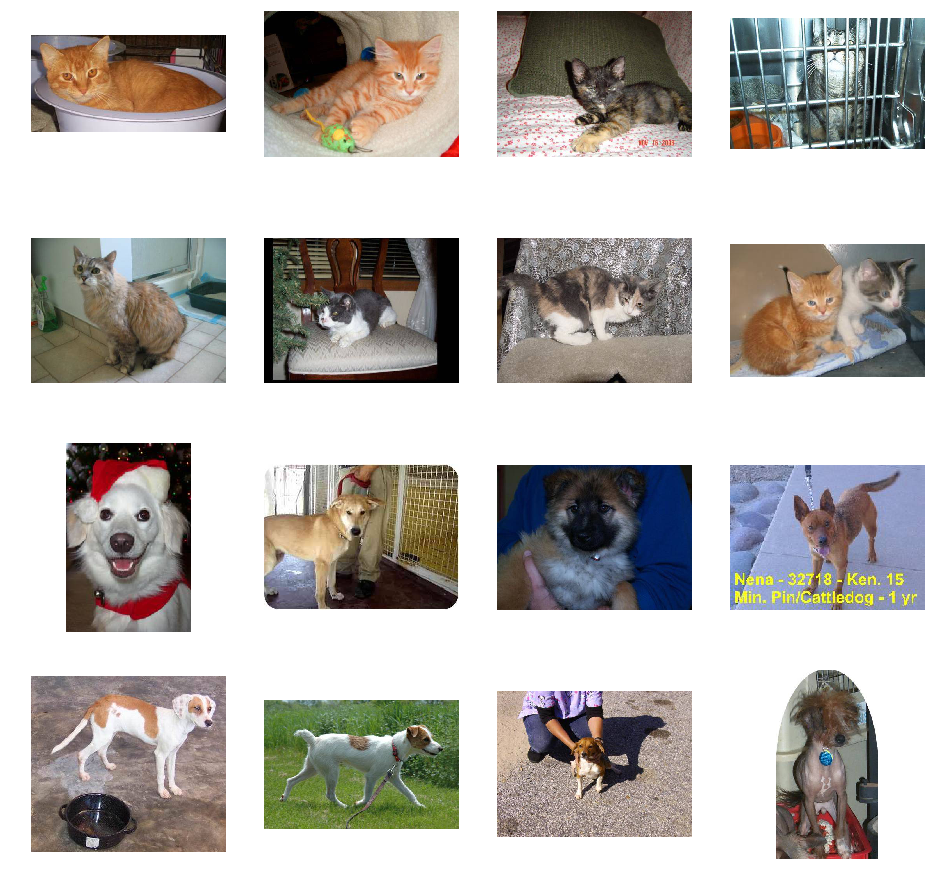

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 設定顯示列數(row)及行數(col)皆為4
nrows = 4
ncols = 4

# 圖像索引編號
pic_index = 0

# 設定繪圖參數使其可容納4x4張圖像
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# 設定下一次顯示圖像內容，貓狗各8張
pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

# 將取得圖像內容繪製至容器中
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # 取消軸標示及格線

  img = mpimg.imread(img_path)
  plt.imshow(img)

# 顯示結果
plt.show()

---

**1.4 自定義資料集及掛載**

---

同理可知，當大家想訓練自己的資料集進行二分類時，首先要準備二組已標註過的圖片(比方說貓和狗)，檔名統一為類別名稱.數字.jpg(數字從0開始)。建議圖片數量不宜太少，否則訓練時容易產生過擬合問題，造成面對真實數據時正確率會驟降。

接著，這兩組圖片的每一組還要再分成兩部份，一部份作為訓練用，另一部份作為驗證用，分別放入\train及\validation路徑下。通常訓練及驗證的數量比例建議在2 : 1 ~ 5 : 1，比例不宜太高。

假設自定義資料集(dataset)中有A和B二個子集圖片，待訓練各1000張圖片，待驗證各500張圖片，則存放方式如下：

![dataset_architeture](https://raw.githubusercontent.com/OmniXRI/Colab_Dogs_and_Cats/master/dataset_architeture.jpg)

最後把資料集壓縮成dataset.zip 放到Google雲端硬碟上，點選檔案按下滑鼠右鍵，選擇「取得檔案共用連結」，取得id=XXXXXXXXXXXXXX的**XXXXXXXXXXXXXX**，填入下方指令中，

!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=XXXXXXXXXXXXXX"  -O /tmp/dataset.zip 

取代1.1節原有指令，並將1.2節相關路徑名也改成自定義名稱即可進行訓練。

**註：下列代碼將展示如何將Google雲端硬碟上自定義的資料集(dataset.zip)複製到虛擬機上/tmp路徑的作法。由於下列代碼為補充資料並非本範例一部份，若欲使用請自行去除＃字註解符號並修改自定義檔案夾及檔案名稱後再進行測試。**

In [0]:
## 將Google雲端硬碟上的資料集複製到虛擬機上/tmp路徑下
## 若取得的檔案共用連結為https://drive.google.com/open?id=XXXXXXXXXXXXXX
#!wget --no-check-certificate \
#    "https://drive.google.com/uc?export=download&id=XXXXXXXXXXXXXX" \
#    -O /tmp/dataset.zip

#import os
#import zipfile

## 將下載到的資料集解壓縮至/tmp
#local_zip = '/tmp/dataset.zip'
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('/tmp')
#zip_ref.close()

## 取得資料集路徑
#base_dir = '/tmp/dataset'
#train_dir = os.path.join(base_dir, 'train')
#validation_dir = os.path.join(base_dir, 'validation')

#train_A_dir = os.path.join(train_dir, 'A')           # 取得訓練用A圖片的路徑
#train_B_dir = os.path.join(train_dir, 'B')           # 取得訓練用B圖片的路徑
#validation_A_dir = os.path.join(validation_dir, 'A') # 取得驗證用A圖片的路徑
#validation_B_dir = os.path.join(validation_dir, 'B') # 取得驗證用B圖片的路徑

#train_A_fnames = os.listdir(train_A_dir)              # 取得訓練用所有A圖片
#train_B_fnames = os.listdir(train_B_dir)              # 取得訓練用所有B圖片
#validation_A_fnames = os.listdir(validation_A_dir)    # 取得驗證用所有A圖片
#validation_B_fnames = os.listdir(validation_B_dir)    # 取得驗證用所有B圖片

#2. 建構小型深度學習模型

---

**2.1 卷積網路模型**

---

為了讓大家更容易了解如何利用TensorFlow及Keras建構一個深度學習模型，這裡展示了一個小型的卷積神經網路(Convolution Neural Network, CNN)，共有三層卷積層(包含ReLu及Max Pooling)，每個卷積層皆用3x3的濾波器進行卷積動作，三層分別提取16, 32及64組濾波器。接著展開成獨立節點後，再加入二層全連結層，分別為512及1個節點，而最後得到的那一個節點加上Sigmodid函數即為最終輸出的結果。其值介於0.0 ~ 1.0，當值越接近1.0時圖片為狗的機率越高，反之輸出值越接近0.0時圖片判定是貓的機率越高。

這個模型雖然不大，但可適用各種圖像分類問題，大家可試著導入自己準備的圖像進行測試。

---

**2.2 輸入圖像尺寸正規化**

---

接著說明輸入(層)資料問題。由於資料集的每張圖片大小、長寬比都不一樣，這樣無法直接進入訓練模型，因此須將影像尺寸統一縮小到指定尺寸。在這個範例中會將圖片統一縮至150x150像素，而色彩依然保持全彩(RGB 3通道)，所以對輸入層來說等於150x150x3。至於影像縮小後造成影像變形導致訓練結果有些許不同的問題是另一層次問題，在此先忽略不予考慮。

---

**2.3 模型架構及訓練參數說明**

---

1.   輸入層為150x150x3的資料，其中的3表示RGB三個通道。

2.   經過第一卷積層(Conv2D)的共產生16組3x3x3濾波器並搭配ReLu激活(Activation)函數，每一組濾波器另加上一個偏置值(Bias)一起訓練，故共有 (3x3x3+1)x16=448個參數待訓練。經過卷積後圖像大小變成148x148x16。

3.   接著以2x2窗口進行最大池化(Max Pooling)動作，取出四個值中最大值，同時將圖像縮小至一半尺寸74x74x16。這個部份不會產生待訓練參數。

4.   再來是第二卷積層(Conv2D)，這項動作類似步驟2，產生32組3x3x16濾波器，同樣搭配ReLu激活(Activation)函數，每一組濾波器另加上一個偏置值(Bias)一起訓練，故共有 (3x3x16+1)x32=4,640個參數待訓練。經過卷積後圖像大小變成72x72x32。

5.   接著同樣以2x2窗口進行最大池化(Max Pooling)動作，取出四個值中最大值，同時將圖像縮小至一半尺寸36x36x32。這個部份不會產生待訓練參數。

6.   再來進行第三卷積層(Conv2D)的共產生64組3x3x32濾波器並搭配ReLu激活(Activation)函數，每一組濾波器另加上一個偏置值(Bias)一起訓練，故共有 (3x3x32+1)x64=18,496個參數待訓練。經過卷積後圖像大小變成34x34x64。

7.   接著以2x2窗口進行最大池化(Max Pooling)動作，取出四個值中最大值，同時將圖像縮小至一半尺寸17x17x64。這個部份不會產生待訓練參數。

8.   接著將所有節點展開(Flatten)變成一維節點準備進行下一階段的全連結網路，共有17x17x64=18,496個節點。

9.   再來以512個節點和上一層進行全連結(Dense)，並搭配ReLu激活函數，再加上一個偏置值(Bias)一起訓練，故共有(18,496+1)x512=9,470,464個參數待訓練。

10.  最後只留一個輸出節點和上一層進行全連結(Dense)並搭配Sigmoid激活函數來產生最後輸出結果，加上一個偏置值(Bias)，故共有512+1=513個參數待訓練。

11.  合計共有9,494,561個參數待訓練。

In [6]:
import tensorflow as tf

from keras.models import Model
from keras import layers
from keras import backend as K

# Configure the TF backend session
tf_config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(allow_growth=True))
K.set_session(tf.Session(config=tf_config))

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

# 展示模型結構及各層所需訓練參數
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
__________

Using TensorFlow backend.


---

**2.4 模型配置及訓練優化設定**

---

接下來配置模型訓練的規格。這裡用binary_crossentropy損失來訓練模型，因為這個範例是一個二元分類問題，而最終激活函數是sigmoid。 而優化器部份使用rmsprop自動學習速率調速，學習速率初始為0.001。 在訓練期間，需監控分類的準確性。

補充說明一下，使用RMSprop優化算法優於隨機梯度下降（SGD），因為RMSprop為我們實現了自動學習速率調整。而其它如Adam和Adagrad等優化器也會在訓練期間自動調整學習速率，若使用在本範例亦可以很好地工作。

In [0]:
from keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

---

**2.5 數據預處理**

---

由於待訓練及驗證的圖片中每像素的數值是介於[0,255] (int整數)，所以使用前要將數值正規化(rescale)到 [0,1] (32bit浮點數)之間，即所有資料都乘上1.0/255，以利後續計算。

另外由於受限於記憶體大小，所以一次不能取入太多圖片進行訓練，在這裡設定批量大小(Batch Size)為一次讀取20張圖片。

接著設置數據產生器，它將讀取源文件夾中的圖片，然後將標註標籤(路徑名稱）輸入到模型(網路)中，同時指定圖片尺寸縮小至150x150，批量讀取大小為20張圖片，分類方式為二進制(非0即1)，再各別生成訓練及驗證用數據產生器。

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#3. 訓練及驗證模型準確度

---

**3.1 訓練及驗證模型**

---

當準備好資料集、深度學習模型(卷積神經網路)及資料產生器後，便可開始執行訓練及驗證。訓練前可指定訓練迭代(epochs)次數，一開始不用設定太多次，主要先確認每次迭代是否有令正確率(Accuracy)是否有逐漸提高。

在執行過程中，每次迭代會輸出訓練的損失率(loss)、正確率(acc)及驗證的損失率(val_loss)及正確率(val_acc)。通常正常率不一定每次都向上升(損失率下降)，有時會產生振盪(忽高忽低)，這是正常的，只要有逐漸收歛(高低變動幅度趨近零)即可。

本範例迭代次數僅設定15次，在K80 GPU環境下每次迭代約10秒左右，最後得到的正確率(val_acc)為0.716(約72%)。若想再將正確率提高些，一般來說可增加迭代次數，但在這裡訓練的正確率(acc)已達0.99，此時再增加迭代次數可能對正確率提高已沒有太大助益，建議要增加資料集的數量才會較有幫助。

In [9]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15
 - 12s - loss: 1.8586 - acc: 0.5475 - val_loss: 0.6508 - val_acc: 0.5700
Epoch 2/15
 - 10s - loss: 0.6171 - acc: 0.6745 - val_loss: 0.6237 - val_acc: 0.6810
Epoch 3/15
 - 10s - loss: 0.5495 - acc: 0.7240 - val_loss: 0.6192 - val_acc: 0.6600
Epoch 4/15
 - 10s - loss: 0.4481 - acc: 0.7900 - val_loss: 0.7177 - val_acc: 0.6900
Epoch 5/15
 - 10s - loss: 0.4057 - acc: 0.8225 - val_loss: 0.7284 - val_acc: 0.6790
Epoch 6/15
 - 10s - loss: 0.2959 - acc: 0.8840 - val_loss: 0.7689 - val_acc: 0.6780
Epoch 7/15
 - 10s - loss: 0.2163 - acc: 0.9055 - val_loss: 1.0787 - val_acc: 0.6860
Epoch 8/15
 - 10s - loss: 0.1517 - acc: 0.9400 - val_loss: 1.1942 - val_acc: 0.6680
Epoch 9/15
 - 10s - loss: 0.0961 - acc: 0.9665 - val_loss: 1.4082 - val_acc: 0.6780
Epoch 10/15
 - 10s - loss: 0.1348 - acc: 0.9695 - val_loss: 1.2492 - val_acc: 0.6810
Epoch 11/15
 - 10s - loss: 0.0804 - acc: 0.9770 - val_loss: 1.6823 - val_acc: 0.6940
Epoch 12/15
 - 10s - loss: 0.0643 - acc: 0.9840 - val_loss: 1.6899 - val_a


---

** 3.2 評估模型的準確性和損失**

---

為了能更方便了解訓練及驗證過程的正確率(Accuracy)及損失率(Loss)，可利用訓練過程(上 一步驟的變數history)所收集到的數據以折線圖方式繪出圖表。代碼執行後會產生兩個圖表，第一個為正確率，第二個為損失率，橫軸代表迭代次數(Epoch)，縱軸代表正確(或損失)率，而藍線代表訓練集結果，而綠線代表驗證集結果。

從圖表中可看出藍線在第十次正確率就已超過0.97(97%)，而損失率已趨近0，但綠色的線正確率卻沒有繼續變高，且損失率反而逐漸增高，這表示訓練過程已造成過擬合(over fitting)的狀況，需要加入更多不同樣態及更多數量的資料集再重新訓練才能改善。至於如何以更多方式解決過擬合問題不在本範例討論範圍。

**註：下列代碼僅用於表達模型訓練及驗證過程的損失率及正確率變化，可忽略不執行。**

Text(0.5,1,'Training and validation loss')

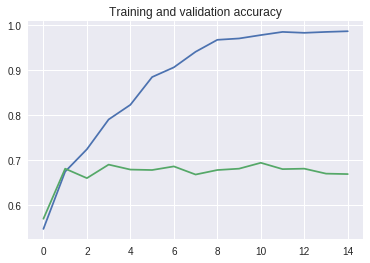

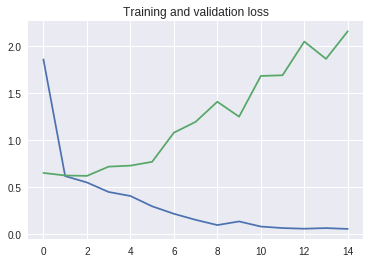

In [10]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

#4. 應用深度學習訓練成果進行推論

---

**4.1  推論**

---

接著就可利用前面訓練好的模型(model)來加以推論(或稱為預測)。這裡我們隨機從驗證圖集中選出一張圖片(每次執行都會選取不同貓狗圖像)，當然你也可以另外準備。再來要將圖像轉成矩陣資料並正規化，即把圖像尺寸縮小至150x150，數值從int8轉成Float32並使值變成0.0 ~ 1.0之間(原數據除以255)。另外請注意，不可把訓練圖像拿來測試，因為在訓練正確度已達0.99情況下，訓練的圖像經推論結果狗的圖片會接近1.0，貓的圖片會接近0.0，這樣無法得知一般貓狗圖片分類的能力。

接著進行推論，會得到圖像分類結果分數，而分數越接近1.0則表示是狗的機率越高，反之越接近0.0則越可能是貓。我們可以再設幾個自定義門檻值來區隔分類結果，比方說「這是狗」、「這可能是狗」、「這可能是貓」、「這是貓」等不同結果描述。

為方便觀察運算時間，可以在執行前後加入計時器(time.time)，再以後者減前者即可得知。在本範例中推論一次約4 ~5 ms(不包含圖像讀入及正規化時間)，已可達一般應用水準。

Result = 0.000000
Test time :0.046284 second.
This is a cat


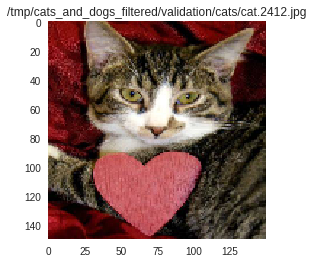

In [11]:
import numpy as np
import random
from keras.preprocessing.image import img_to_array, load_img

# Let's prepare a random input image of a cat or dog from the validation set.
cat_img_files = [os.path.join(validation_cats_dir, f) for f in validation_cat_fnames]
dog_img_files = [os.path.join(validation_dogs_dir, f) for f in validation_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

# 讀入待測試圖像並秀出
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
plt.title(img_path)
plt.grid(False)
plt.imshow(img)

# 將圖像轉成模型可分析格式(150x150x3, float32)
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
x /= 255 # Rescale by 1/255

import time
start = time.time() # 啟動計時器

result = model.predict(x) # 對輸入圖像進行推論(預測)

finish = time.time() # 結束計時器

print ("Result = %f" %result) # 印出結果可能機率值(0.0 ~ 1.0)
print("Test time :%f second." %(finish-start)) # 印出推論時間

#設定分類門檻值並印出推論結果
dog_threshold = 0.6
mid_threshold = 0.4
cat_threshold = 0.2

if result > dog_threshold:    # result 介於0.6 至 1.0 為狗
    print("This is a dog.") 
elif result >= mid_threshold: # result 介於0.4 至 0.6 可能為狗
    print("Maybe is a dog")
elif result < cat_threshold:  # result 介於0.2 至 0.4 可能為貓
    print("This is a cat")
else:                         # result 介於0.0 至 0.2 為貓
    print("Maybe is a cat.")

---

**4.2  可視化表示**

---

為了讓大家更了解深度學習模型運作方式，所以將各層運作結果輸出到特徵圖中，再逐一秀出。輸入層尺寸為150x150共有3組(RGB三通道)。第一卷積層共產生16個特徵圖，conv2d_1尺寸為148x148，max_pooling2d_1尺寸為74x74。第二卷積層共產生32個特徵圖，conv2d_2尺寸為72x72，max_pooling_2為36x36。第三卷積層共產生64個特徵圖，conv2d_3尺寸為34x34，max_pooling_3為17x17。最後的全連結層(dense)為單一節點資訊，不易以圖形方式表示，故忽略不處理。

從各層特徵圖中可看出，隨著影像尺寸縮小其被激活的像素越來越少，甚至完全不輸出(全黑)，表示其特徵已被某些卷積(濾波器)給凸顯出來。對於我們所需的圖像分類(辨識)能力也逐漸增強了。

**註：以下代碼僅幫助大家了解模型各層運作結果，可忽略不執行。**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


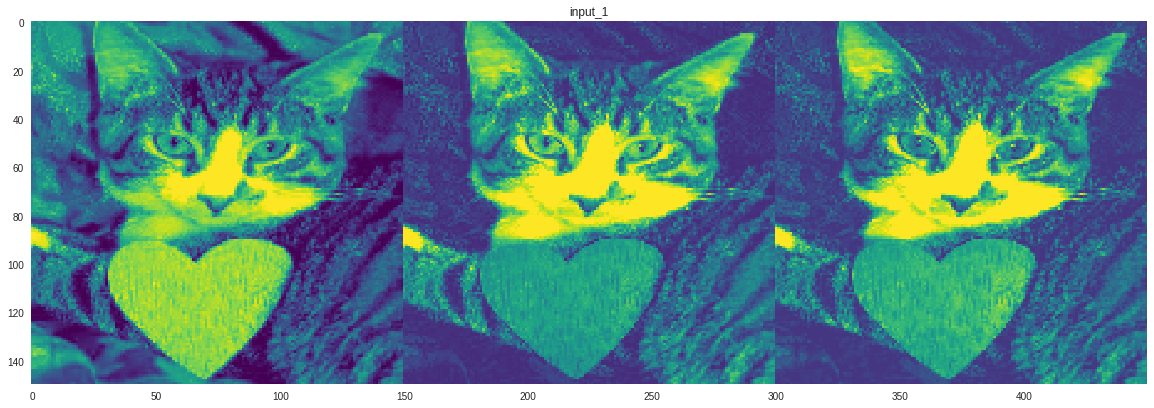

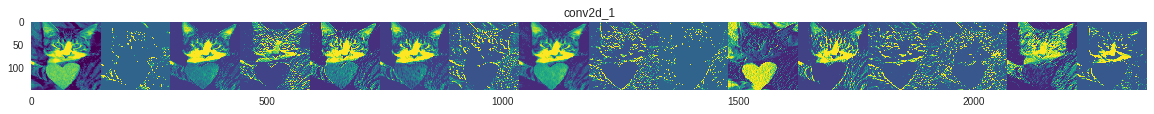

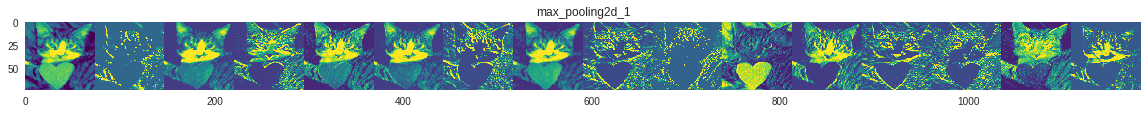

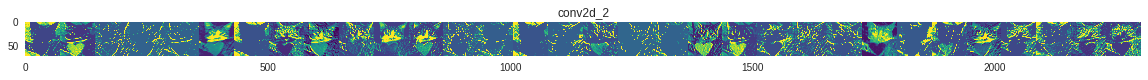

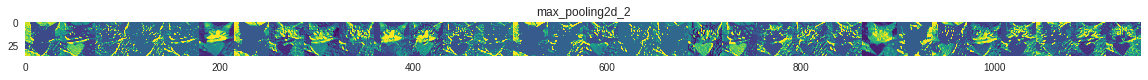

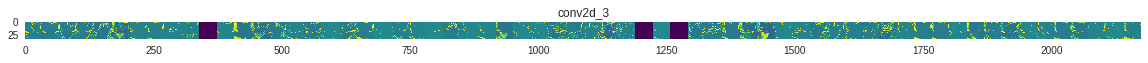

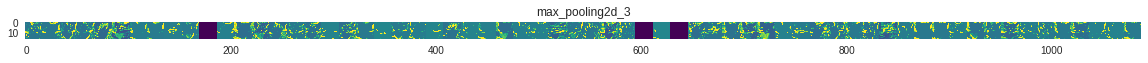

In [12]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model.
successive_outputs = [layer.output for layer in model.layers]
visualization_model = Model(img_input, successive_outputs)

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# 結論

Google Colaboratory這項免費的雲端GPU資源實在很方便剛入門的伙伴進行**「深度學習」**(一語雙關)，它不會因為個人電腦(筆電)的配備等級不同而影響模型訓練及推論的效能，同時更可輕易的分享代碼給其它想學的人，對開源社群更是一大助力。希望不久的將來有更多伙伴能一起加入研究及分享，讓更多人工智能的應用能加速落地。

**最後提醒一下，如果想要進行另一個練習時，建議去除下列代碼#字號，執行後可中斷連結並把所有記憶體資源釋放掉。**

In [0]:
#import os, signal
#os.kill(os.getpid(), signal.SIGKILL)